In [1]:
from matplotlib import pyplot as plt
import h5py
import numpy as np
from tqdm import *
from scipy import spatial
import matplotlib.gridspec as gridspec
import stats

cdm = h5py.File('Data/COLOR_CDM_DM_subHaloes_z0.00_v2.hdf5', 'r')
wdm = h5py.File('Data/COLOR_WDM_DM_subHaloes_z0.00_v2.hdf5', 'r')

cdm_galaxy = h5py.File('Data\COLOR_CDM_galaxies.hdf5', 'r')
wdm_galaxy = h5py.File('Data\COLOR_WDM_galaxies.hdf5', 'r')

print(cdm,wdm,cdm_galaxy,wdm_galaxy)

<HDF5 file "COLOR_CDM_DM_subHaloes_z0.00_v2.hdf5" (mode r)> <HDF5 file "COLOR_WDM_DM_subHaloes_z0.00_v2.hdf5" (mode r)> <HDF5 file "COLOR_CDM_galaxies.hdf5" (mode r)> <HDF5 file "COLOR_WDM_galaxies.hdf5" (mode r)>


# Calculate Jackknife error bars
### Start with the halo correlation function

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


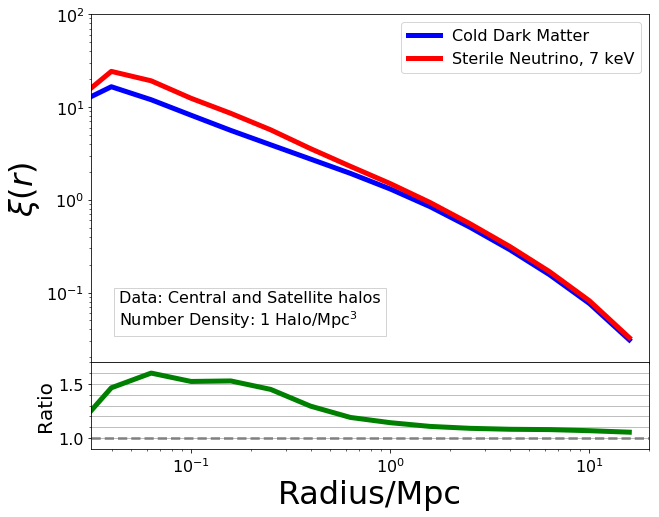

In [14]:
CUTE_cdm_sorted = np.genfromtxt("Output/corr_cdm_pos_sorted.txt", usecols = (0,1))
CUTE_wdm_sorted = np.genfromtxt("Output/corr_wdm_pos_sorted.txt", usecols = (0,1))

textstr = '\n'.join((
    r'Data: Central and Satellite halos',
    r'Number Density: 1 Halo/Mpc$^{3}$'))
props = dict(facecolor='none', edgecolor='lightgrey', pad = 5.0)

plt.figure(figsize=(10,8))
grid = gridspec.GridSpec(2,1, height_ratios = [4,1])
grid.update(hspace = 0)
grid0 = plt.subplot(grid[0])
grid1 = plt.subplot(grid[1])

grid0.loglog(CUTE_cdm_sorted[:,0], CUTE_cdm_sorted[:,1], label = "Cold Dark Matter",  linewidth = 5, color = "blue")
grid0.loglog(CUTE_wdm_sorted[:,0], CUTE_wdm_sorted[:,1], label = "Sterile Neutrino, 7 keV",  linewidth = 5, color = "red")
grid0.set_xlim(10**-1.5, 2e1)
grid0.set_ylim(10**-1.75, 10**2)
grid0.set_ylabel(r"$\xi(r)$", fontsize = 32)
grid0.legend(fontsize=16)
grid0.minorticks_on()
grid0.tick_params(labelsize=16)
grid0.text(0.05, 0.2, textstr, transform=grid0.transAxes, fontsize=16, verticalalignment='top', bbox=props)

grid1.semilogx(CUTE_wdm_sorted[:,0], CUTE_wdm_sorted[:,1]/CUTE_cdm_sorted[:,1],  linewidth = 5, color = "green")
grid1.set_xlabel("Radius/Mpc", fontsize = 32)
grid1.set_ylabel("Ratio",  fontsize = 20)
grid1.axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
grid1.set_xlim(10**-1.5, 2e1)
grid1.set_ylim(0.9, 1.7)
grid1.minorticks_on()
grid1.tick_params(labelsize=16)
grid1.yaxis.grid(which = "both")

plt.savefig('test2.pdf')
plt.show()

In [3]:
# Access the halo positions for wdm/cdm
cdm_position = np.genfromtxt("Input/cdm_pos_sorted.txt")
wdm_position = np.genfromtxt("Input/wdm_pos_sorted.txt")

### Split the volume into 27 subvolumes (cubes)

In [4]:
def sublength(position,i):
    length = 100/3 # Mpc

    position1=position[position[:,i]<length]
    position2=position[(position[:,i]>length) & (position[:,i]<2*length)]
    position3=position[position[:,i]>2*length]
    
    return [position1,position2,position3]

def subvolume(volume,i):
    return [sublength(volume[0],i),sublength(volume[1],i),sublength(volume[2],i)]

In [5]:
#split along the x-direction
cdm_subvolume=sublength(cdm_position,0)
wdm_subvolume=sublength(wdm_position,0)

In [6]:
#split along the y-direction
cdm_subvolume=subvolume(cdm_subvolume,1)
wdm_subvolume=subvolume(wdm_subvolume,1)

In [7]:
#split along the z-direction
cdm_subvolume=[subvolume(cdm_subvolume[0],2),subvolume(cdm_subvolume[1],2),subvolume(cdm_subvolume[2],2)]
wdm_subvolume=[subvolume(wdm_subvolume[0],2),subvolume(wdm_subvolume[1],2),subvolume(wdm_subvolume[2],2)]

np.array(cdm_subvolume).shape,np.array(wdm_subvolume).shape

((3, 3, 3), (3, 3, 3))

In [267]:
n=3
for i in range(n):
    for j in range(n):
        for k in range(n):
            np.savetxt("Input/cdm_subvolume_"+str(i)+str(j)+str(k)+".txt", cdm_subvolume[i][j][k], fmt = "%f %f %f")
            np.savetxt("Input/wdm_subvolume_"+str(i)+str(j)+str(k)+".txt", wdm_subvolume[i][j][k], fmt = "%f %f %f")

### Obtain the indices of the halos within each subvolume

In [8]:
def sublength(position,i):
    length = 100/3 # Mpc
    
    ind1=np.where(position[:,i]<length)[0]
    ind2=np.where((position[:,i]>length) & (position[:,i]<2*length))[0]
    ind3=np.where(position[:,i]>2*length)[0]
    
    return [ind1,ind2,ind3]

def subvolume(position,ind,i):
    n,volume_ind=3,[[],[],[]]
    for j in range(n):
        for k in range(n):
            volume_ind[j].append(ind[j][sublength(position[ind[j]],i)[k]])
    return volume_ind

In [9]:
#split along the x-direction
cdm_subvolume_ind=sublength(cdm_position,0)
wdm_subvolume_ind=sublength(wdm_position,0)

In [10]:
#split along the y-direction
cdm_subvolume_ind=subvolume(cdm_position,cdm_subvolume_ind,1)
wdm_subvolume_ind=subvolume(wdm_position,wdm_subvolume_ind,1)

In [11]:
#split along the z-direction
cdm_subvolume_ind=[subvolume(cdm_position,cdm_subvolume_ind[0],2),
                   subvolume(cdm_position,cdm_subvolume_ind[1],2),
                   subvolume(cdm_position,cdm_subvolume_ind[2],2)]

wdm_subvolume_ind=[subvolume(wdm_position,wdm_subvolume_ind[0],2),
                   subvolume(wdm_position,wdm_subvolume_ind[1],2),
                   subvolume(wdm_position,wdm_subvolume_ind[2],2)]

np.array(cdm_subvolume_ind).shape,np.array(wdm_subvolume_ind).shape

((3, 3, 3), (3, 3, 3))

### Obtain 27 subsamples by deleting each subvolume

In [24]:
n,cdm_subsample,wdm_subsample=3,[[[],[],[]],[[],[],[]],[[],[],[]]],[[[],[],[]],[[],[],[]],[[],[],[]]]
for i in range(n):
    for j in range(n):
        for k in range(n):
            cdm_subsample[i][j].append(np.delete(cdm_position,cdm_subvolume_ind[i][j][k],axis=0))
            wdm_subsample[i][j].append(np.delete(wdm_position,wdm_subvolume_ind[i][j][k],axis=0))
            
            np.savetxt("Input/cdm_subsample_"+str(i)+str(j)+str(k)+".txt", cdm_subsample[i][j][k], fmt = "%f %f %f")
            np.savetxt("Input/wdm_subsample_"+str(i)+str(j)+str(k)+".txt", wdm_subsample[i][j][k], fmt = "%f %f %f")

In [54]:
x,y,z=2,2,1
np.where((cdm_subsample[x][y][z][:,0]>2*100/3) & (cdm_subsample[x][y][z][:,1]>2*100/3) & 
         ((cdm_subsample[x][y][z][:,2]>100/3) & (cdm_subsample[x][y][z][:,2]<2*100/3)))

(array([], dtype=int64),)

### Compute the correlation function for each subsample

In [20]:
#write a script
import subprocess

def main():
    """ Main function to be run."""

    # list of input files
    files = ['cdm_subsample_000.txt', 'cdm_subsample_001.txt', 'cdm_subsample_002.txt', 'cdm_subsample_010.txt',
             'cdm_subsample_011.txt', 'cdm_subsample_012.txt', 'cdm_subsample_020.txt', 'cdm_subsample_021.txt',
             'cdm_subsample_022.txt', 'cdm_subsample_100.txt', 'cdm_subsample_101.txt', 'cdm_subsample_102.txt',
             'cdm_subsample_110.txt', 'cdm_subsample_111.txt', 'cdm_subsample_112.txt', 'cdm_subsample_120.txt',
             'cdm_subsample_121.txt', 'cdm_subsample_122.txt', 'cdm_subsample_200.txt', 'cdm_subsample_201.txt',
             'cdm_subsample_202.txt', 'cdm_subsample_210.txt', 'cdm_subsample_211.txt', 'cdm_subsample_212.txt',
             'cdm_subsample_220.txt', 'cdm_subsample_221.txt', 'cdm_subsample_222.txt', 'wdm_subsample_000.txt',
             'wdm_subsample_001.txt', 'wdm_subsample_002.txt', 'wdm_subsample_010.txt', 'wdm_subsample_011.txt',
             'wdm_subsample_012.txt', 'wdm_subsample_020.txt', 'wdm_subsample_021.txt', 'wdm_subsample_022.txt',
             'wdm_subsample_100.txt', 'wdm_subsample_101.txt', 'wdm_subsample_102.txt', 'wdm_subsample_110.txt',
             'wdm_subsample_111.txt', 'wdm_subsample_112.txt', 'wdm_subsample_120.txt', 'wdm_subsample_121.txt',
             'wdm_subsample_122.txt', 'wdm_subsample_200.txt', 'wdm_subsample_201.txt', 'wdm_subsample_202.txt',
             'wdm_subsample_210.txt', 'wdm_subsample_211.txt', 'wdm_subsample_212.txt', 'wdm_subsample_220.txt',
             'wdm_subsample_221.txt', 'wdm_subsample_222.txt']

    # script to run the correlation function on each input file
    for file in files:
        
        #open the parameters file for writing
        params = open('test/params.txt', "w") 
        
        # rewrite the parameters file with the correct input file
        params.write("#input information\n
        data_filename= input/"+file+"\n
        num_lines= all\n
        input_format= 0\n
        output_filename= output/"+file+"\n
        box_size= 100.\n
        \n
        #tree stuff\n
        use_tree= 0\n
        max_tree_order= 6\n
        max_tree_nparts= 100\n
        \n
        #irrelevant yet\n
        use_pm= 0\n
        n_grid_side= 256")

        # compute the correlation function using this new parameters file
        subprocess.call(['./CUTE_box','test/params.txt'])
    
if __name__ == "__main__":
    main()

SyntaxError: EOL while scanning string literal (<ipython-input-20-73a3a1a25a5c>, line 20)